# Definition of Spline Interpolation

We want to create a spline $s(x)$ such that

$$
s(x) = 
\begin{cases}
s_0(x) &, &x \in [t_0, t_1) \\
s_1(x) &, &x \in [t_1, t_2) \\
&... \\
s_{n-1}(x) &, &x \in [t_{n-1}, t_n)
\end{cases}
$$

Given $h_i = t_{i+1} - t_i$, for each $s_i$, it is

$$
s_i(x) = \frac{z_{i+1}}{6h_i}(x - t_i)^3 + \frac{z_i}{6h_i}(t_{i+1} - x)^3 + (\frac{y_{i+1}}{h_i} - \frac{z_{i+1}h_i}{6})(x-t_i)+(\frac{y_i}{h_i} - \frac{z_ih_i}{6})(t_{i+1} - x)
$$

where $z_1, z_2, ..., z_{n-1}$ are calculated from the linear equation that

$$
\begin{align*}
\begin{bmatrix}
\frac{h_0 + h_1}{3} & \frac{h_1}{6} & 0 & 0 & ... & 0 & 0 & 0 \\
\frac{h_1}{6} & \frac{h_1 + h_2}{3} & \frac{h_2}{6} & 0 & ... & 0 & 0 & 0 \\
&...&...&&...&&...& \\
0 & 0 & 0 & 0 & ... & \frac{h_{n-3}}{6} & \frac{h_{n-3} + h_{n-2}}{3} & \frac{h_{n-2}}{6} \\
0 & 0 & 0 & 0 & ... & 0 & \frac{h_{n-2}}{6} &  \frac{h_{n-2} + h_{n-1}}{3}
\end{bmatrix}
\begin{bmatrix}
z_1 \\
z_2 \\
... \\
z_{n-2} \\
z_{n-1}
\end{bmatrix}
&=
\begin{bmatrix}
\frac{y_2-y_1}{h_1} - \frac{y_1-y_0}{h_0} \\
\frac{y_3-y_2}{h_2} - \frac{y_2-y_1}{h_1} \\
...\\
\frac{y_{n-1}-y_{n-2}}{h_{n-2}} - \frac{y_{n-2}-y_{n-3}}{h_{n-3}} \\
\frac{y_n-y_{n-1}}{h_{n-1}} - \frac{y_{n-1}-y_{n-2}}{h_{n-2}}
\end{bmatrix} \\
HZ &= Y \\
H^{-1} HZ &= H^{-1} Y \\
Z &= H^{-1} Y
\end{align*}
$$

and $z_0 = z_n = 0$

# Implementation

In [3]:
using LinearAlgebra

In [4]:
function calculateZ(Xs::Vector{Float64}, Ys::Vector{Float64}, n::Int64, assumeEndZeros::Bool = true)::Vector{Float64}
    du::Vector{Float64} = []  # upper diag elements
    dd::Vector{Float64} = []
    dl::Vector{Float64} = []
    
    Y::Matrix{Float64} = zeros(Float64, n - 2, 1)
    
    # push elements into du dd dl
    # $h_i = t_{i+1} - t_i$
    for i in 1:n-2
        if i > 1
            h = Xs[i] - Xs[i - 1]
            push!(dl, h / 6.0)
        end
        if i < n - 2
            h = Xs[i + 2] - Xs[i + 1]
            push!(du, h / 6.0)
        end
        h1_h2 = Xs[i + 2] - Xs[i]
        push!(dd, h1_h2 / 3.0)
        
        Y[i, 1] = (Ys[i + 2] - Ys[i + 1]) / (Xs[i + 2] - Xs[i + 1]) - (Ys[i + 1] - Ys[i]) / (Xs[i + 1] - Xs[i])
    end
    
    # build H
    H::Tridiagonal{Float64, Vector{Float64}} = Tridiagonal(dl, dd, du)
    
    # calculate Z
    Zmat::Matrix{Float64} = inv(H) * Y
    Z::Vector{Float64} = vec(Zmat)
    
    if assumeEndZeros
        push!(Z, 0.0)
        pushfirst!(Z, 0.0)
    end
    
    return Z
end

calculateZ (generic function with 2 methods)

In [5]:
function splineInterpolation(data::Dict{Float64, Float64}, x::Float64, Z::Union{Vector{Float64}, Nothing} = nothing)::Float64
    # determine which interval x is in
    Xs::Vector{Float64} = sort(collect(keys(data)))
    Ys::Vector{Float64} = [data[i] for i in Xs]
    n::Int64 = length(Xs)
    
    if isnothing(Z)
        Z::Vector{Float64} = calculateZ(Xs, Ys, n)
    end
    
    for i in 1:n-1
        if (i == 1 && x < Xs[i]) || Xs[i] <= x < Xs[i + 1] || (i == n - 1 && x >= Xs[i])
            h = Xs[i + 1] - Xs[i]
            return Z[i + 1] / 6.0 / h * (x - Xs[i])^3.0 + Z[i] / 6.0 / h * (Xs[i + 1] - x)^3 + (Ys[i + 1] / h - (Z[i + 1] * h) / 6.0) * (x - Xs[i]) + (Ys[i] / h - Z[i] * h / 6.0) * (Xs[i + 1] - x)
        end
    end
end

splineInterpolation (generic function with 2 methods)

# Interpolate a sample data

Given $y = f(x)$ be a function that:

| $i$ | $0$ | $1$ | $2$ | $3$ | $4$ |
|:-:|:-:|:-:|:-:|:-:|:-:|
| $x_i$ | $0$ | $0.5$ | $1$ | $1.5$ | $2.0$ |
| $y_i = f(x_i)$ | $0.5$ | $1.425639$ | $2.640859$ | $4.009155$ | $5.305472$ |
| $f\prime(x_i)$ | $1.5$ | | | | $2.305472$ |

Since $f\prime(0)$ and $f\prime(2.0)$ are specified, we have to calculate $z_0$ and $z_5$ in the way that $z_0, z_5$ may not equal $0$ (I repeat, $z_5$ not $z_4$).

According to the definition,

$$
p_i\prime(t_i) = -\frac{h_i}{3}z_i - \frac{h_i}{6}z_{i+1} - \frac{y_i}{h_i} + \frac{y_{i+1}}{h_i}
$$

For $1 \leq i < n-1$, $p_i\prime(t_i) = p_{i-1}\prime(t_i)$. However, this is not defined for $i \in \{0, n-1\}$.

To mitigate the problem, let

$$
\begin{align*}
p\prime_0(x_0) &:= f\prime(0) \\
p\prime_{n-1}(x_{n-1}) &:= f\prime(x_{n-1})
\end{align*}
$$

Because we already know $h_i$, $z_{i+1}$, $y_i$ and $y_{i+1}$ where $i \in \{0, n-1\}$ (from solving that linear equation),

$$
\begin{align*}
-\frac{h_i}{3}z_i - \frac{h_i}{6}z_{i+1} - \frac{y_i}{h_i} + \frac{y_{i+1}}{h_i} &= f\prime(t_i) \\
-\frac{h_i}{3}z_i &= f\prime(t_i) + \frac{h_i}{6}z_{i+1} + \frac{y_i}{h_i} - \frac{y_{i+1}}{h_i} \\
z_i &= -\frac{3}{h_i}\Big( f\prime(t_i) + \frac{h_i}{6}z_{i+1} + \frac{y_i}{h_i} - \frac{y_{i+1}}{h_i} \Big)
\end{align*}
$$

Meanwhile,

$$
\begin{align*}
- \frac{h_i}{6}z_{i+1} &= f\prime(t_i) + \frac{h_i}{3}z_i + \frac{y_i}{h_i} - \frac{y_{i+1}}{h_i} \\
z_{i+1} &= - \frac{6}{h_i} \Big( f\prime(t_i) + \frac{h_i}{3}z_i + \frac{y_i}{h_i} - \frac{y_{i+1}}{h_i} \Big)
\end{align*}
$$

Therefore,

$$
\begin{align*}
z_0 &= -\frac{3}{h_0}\Big( f\prime(t_0) + \frac{h_0}{6}z_{1} + \frac{y_0}{h_0} - \frac{y_{1}}{h_0} \Big) \\
z_n &= -\frac{6}{h_{n-1}} \Big( f\prime(t_{n-1}) + \frac{h_{n-1}}{3}z_{n-1} + \frac{y_{n-1}}{h_{n-1}} - \frac{y_{n}}{h_{n-1}} \Big)
\end{align*}
$$

In [6]:
data::Dict{Float64, Float64} = Dict(
    0.0 => 0.5,
    0.5 => 1.25639,
    1.0 => 2.640859,
    1.5 => 4.009155,
    2.0 => 5.305472,
)

Dict{Float64, Float64} with 5 entries:
  0.0 => 0.5
  2.0 => 5.30547
  0.5 => 1.25639
  1.5 => 4.00915
  1.0 => 2.64086

In [7]:
Xs::Vector{Float64} = sort(collect(keys(data)))
Ys::Vector{Float64} = [data[x] for x in Xs]

Z::Vector{Float64} = calculateZ(Xs, Ys, length(data), false)

h0 = Xs[2] - Xs[1]
hn_1 = Xs[end] - Xs[end - 1]

z0 = -3.0 / h0 * (1.5 + h0 / 6.0 * Z[1] + Ys[1] / h0 - Ys[2] / h0)
zn = -6.0 / hn_1 * (2.305472 + hn_1 / 3.0 * Z[end] + Ys[end - 1] / hn_1 - Ys[end] / hn_1)

push!(Z, z0)
pushfirst!(Z, zn)

5-element Vector{Float64}:
  3.7775845714285765
  4.034527714285716
 -1.0642148571428574
 -0.16582028571428445
 -1.940583857142859

# Test

In [8]:
using Plots

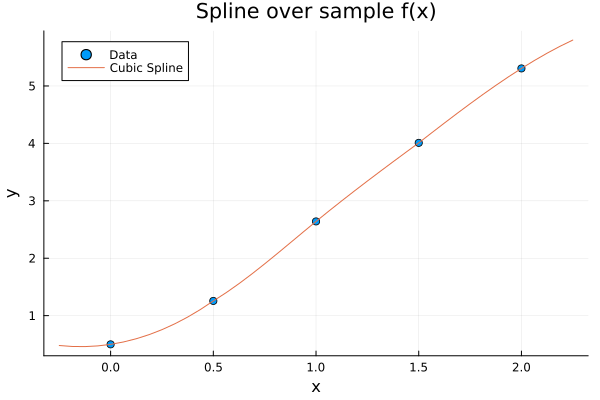

In [9]:
Xhat = -0.25:0.0625:2.25
Yhat = [splineInterpolation(data, x, Z) for x in Xhat]

scatter(Xs, Ys, title="Spline over sample f(x)", xlabel="x", ylabel="y", label="Data")
plot!(Xhat, Yhat, label="Cubic Spline")

Compare to the case given $f\prime(0) = f\prime(n) = 0$

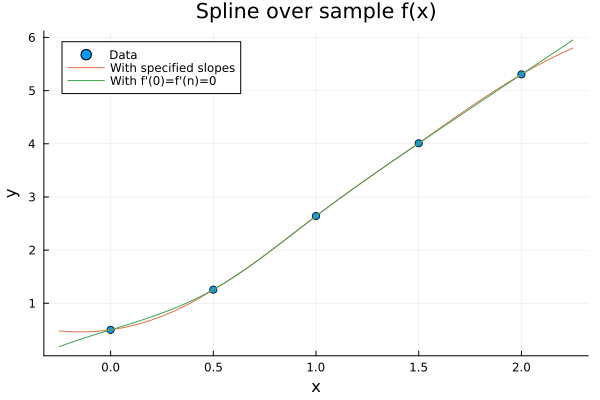

In [10]:
Xhat = -0.25:0.0625:2.25
Yhat = [splineInterpolation(data, x, Z) for x in Xhat]
Yhat2 = [splineInterpolation(data, x) for x in Xhat]

scatter(Xs, Ys, title="Spline over sample f(x)", xlabel="x", ylabel="y", label="Data")
plot!(Xhat, Yhat, label="With specified slopes")
plot!(Xhat, Yhat2, label="With f'(0)=f'(n)=0")

Notice the interval $x \in [0.0, 0.5] \cup [1.5, 2.0]$ that $y$ values are slightly different when the ending derivatives of $f(x)$ are non-zero.

# Approximate $f(0.25)$ and $f(1.25)$

In [11]:
println("f(0.25) = $(splineInterpolation(data, 0.25, Z))")
println("f(1.25) = $(splineInterpolation(data, 1.25, Z))")

f(0.25) = 0.7561307455357141
f(1.25) = 3.3442262991071425
